In [ ]:
# CS 6140 - Machine Learning
# Seq2Seq Model - Attention & Data Cleaning for Playlist Title Generation

# Import necessary libraries
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from collections import Counter
import matplotlib.pyplot as plt
import nltk
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

# Part 1 - Data cleaning

# Load Spotify dataset, remove duplicates
file_path = "spotify_songs.csv"
spotify_df = pd.read_csv(file_path)
spotify_df = spotify_df.drop_duplicates()

# Convert album release date to datetime
spotify_df['track_album_release_date'] = pd.to_datetime(
    spotify_df['track_album_release_date'], errors='coerce'
)

# Drop rows with missing values in key columns
spotify_df_cleaned = spotify_df.dropna(subset=[
    'track_id', 'track_name', 'track_artist',
    'track_album_id', 'track_album_name', 'track_album_release_date'
])

# Filter out invalid values
spotify_df_cleaned = spotify_df_cleaned[
    (spotify_df_cleaned['track_popularity'] >= 0) &
    (spotify_df_cleaned['track_popularity'] <= 100) &
    (spotify_df_cleaned['loudness'] <= 0)
]

# Standardize text columns
spotify_df_cleaned['track_name'] = spotify_df_cleaned['track_name'].str.strip().str.title()
spotify_df_cleaned['track_artist'] = spotify_df_cleaned['track_artist'].str.strip().str.title()
spotify_df_cleaned['playlist_genre'] = spotify_df_cleaned['playlist_genre'].str.strip().str.lower()
spotify_df_cleaned['playlist_subgenre'] = spotify_df_cleaned['playlist_subgenre'].str.strip().str.lower()

# Save cleaned data
spotify_df_cleaned.to_csv("spotify_songs_cleaned.csv", index=False)

In [ ]:
# Part 2 - Model Training

# Load cleaned dataset
df = pd.read_csv("spotify_songs_cleaned.csv")
df = df[['track_name', 'playlist_subgenre']].dropna()
df = df.sample(30000, random_state=42)

# Tokenization
def tokenize(text): return text.lower().split()
track_tokens = df['track_name'].apply(tokenize)
title_tokens = df['playlist_subgenre'].apply(tokenize)

def build_vocab(token_lists):
    counter = Counter(token for tokens in token_lists for token in tokens)
    vocab = {word: i+2 for i, (word, _) in enumerate(counter.items())}
    vocab['<PAD>'] = 0
    vocab['<UNK>'] = 1
    return vocab

input_vocab = build_vocab(track_tokens)
target_vocab = build_vocab(title_tokens)

def encode(tokens, vocab, max_len):
    return [vocab.get(token, 1) for token in tokens[:max_len]] + [0] * (max_len - len(tokens))

MAX_INPUT_LEN = 10
MAX_OUTPUT_LEN = 3

inputs = torch.tensor([encode(t, input_vocab, MAX_INPUT_LEN) for t in track_tokens])
targets = torch.tensor([encode(t, target_vocab, MAX_OUTPUT_LEN) for t in title_tokens])

X_train, X_val, y_train, y_val = train_test_split(inputs, targets, test_size=0.1, random_state=42)

# Attention module
class Attention(nn.Module):
    def __init__(self, hidden_size):
        super().__init__()
        self.attn = nn.Linear(hidden_size * 2, hidden_size)
        self.v = nn.Linear(hidden_size, 1, bias=False)

    def forward(self, hidden, encoder_outputs):
        hidden = hidden.unsqueeze(1).repeat(1, encoder_outputs.shape[1], 1)
        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim=2)))
        attention = self.v(energy).squeeze(2)
        return torch.softmax(attention, dim=1)

# Building encoder
class Encoder(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size, padding_idx=0)
        self.lstm = nn.LSTM(embed_size, hidden_size, batch_first=True)

    def forward(self, x):
        embedded = self.embedding(x)
        outputs, (hidden, cell) = self.lstm(embedded)
        return outputs, hidden, cell

# Decoder with attention
class AttnDecoder(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, attention):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size, padding_idx=0)
        self.lstm = nn.LSTM(hidden_size + embed_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, vocab_size)
        self.attention = attention

    def forward(self, input_token, hidden, cell, encoder_outputs):
        input_token = input_token.unsqueeze(1)
        embedded = self.embedding(input_token)
        attn_weights = self.attention(hidden[-1], encoder_outputs).unsqueeze(1)
        context = torch.bmm(attn_weights, encoder_outputs)
        rnn_input = torch.cat((embedded, context), dim=2)
        output, (hidden, cell) = self.lstm(rnn_input, (hidden, cell))
        prediction = self.fc(output.squeeze(1))
        return prediction, hidden, cell

# Seq2Seq model with attention
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, target_vocab_size, max_len):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.max_len = max_len
        self.target_vocab_size = target_vocab_size

    def forward(self, src, trg):
        batch_size = src.size(0)
        encoder_outputs, hidden, cell = self.encoder(src)
        output_tensor = torch.zeros(batch_size, self.max_len, self.target_vocab_size)
        input_token = trg[:, 0]

        for t in range(1, self.max_len):
            out, hidden, cell = self.decoder(input_token, hidden, cell, encoder_outputs)
            output_tensor[:, t] = out
            input_token = trg[:, t]

        return output_tensor

# Instantiate model
embed_size = 64
hidden_size = 128
attention = Attention(hidden_size)
encoder = Encoder(len(input_vocab), embed_size, hidden_size)
decoder = AttnDecoder(len(target_vocab), embed_size, hidden_size, attention)
model = Seq2Seq(encoder, decoder, len(target_vocab), MAX_OUTPUT_LEN)

# Define loss and optimizer
criterion = nn.CrossEntropyLoss(ignore_index=0)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
NUM_EPOCHS = 10
BATCH_SIZE = 32
epoch_losses = []  # To store loss for each epoch

for epoch in range(NUM_EPOCHS):
    model.train()
    epoch_loss = 0

    for i in range(0, len(X_train), BATCH_SIZE):
        src = X_train[i:i+BATCH_SIZE]
        trg = y_train[i:i+BATCH_SIZE]

        optimizer.zero_grad()
        output = model(src, trg)

        output = output[:, 1:].reshape(-1, model.target_vocab_size)
        trg = trg[:, 1:].reshape(-1)

        loss = criterion(output, trg)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    avg_loss = epoch_loss / (len(X_train) // BATCH_SIZE)
    epoch_losses.append(avg_loss)
    print(f"Epoch {epoch+1} Average Loss: {avg_loss:.4f}")
    print(f"Epoch {epoch+1} Loss: {epoch_loss:.4f}")

# Inference function
def predict_title(track_name, model, input_vocab, target_vocab, max_input_len, max_output_len):
    model.eval()
    tokens = tokenize(track_name)
    input_seq = torch.tensor([encode(tokens, input_vocab, max_input_len)])

    with torch.no_grad():
        encoder_outputs, hidden, cell = model.encoder(input_seq)
        input_token = torch.tensor([target_vocab.get('<PAD>', 0)])
        output_tokens = []

        for _ in range(max_output_len):
            output, hidden, cell = model.decoder(input_token, hidden, cell, encoder_outputs)
            probs = torch.softmax(output, dim=1)

            # Suppress PAD token probability entirely
            probs[0][0] = 0

            pred_token = torch.multinomial(probs, 1).item()
            word = next((k for k, v in target_vocab.items() if v == pred_token), '<UNK>')

            if output_tokens and word == output_tokens[-1]:
                continue  # Skip repeated words for output

            if pred_token == 0:
                break

            output_tokens.append(word)
            input_token = torch.tensor([pred_token])

    return ' '.join(output_tokens).title()

# Basic example
print(predict_title("Bohemian Rhapsody", model, input_vocab, target_vocab, MAX_INPUT_LEN, MAX_OUTPUT_LEN))

Epoch 1 Average Loss: 0.2502
Epoch 1 Loss: 210.9441
Epoch 2 Average Loss: 0.1178
Epoch 2 Loss: 99.2721
Epoch 3 Average Loss: 0.1146
Epoch 3 Loss: 96.5805
Epoch 4 Average Loss: 0.1026
Epoch 4 Loss: 86.5328
Epoch 5 Average Loss: 0.0864
Epoch 5 Loss: 72.8733
Epoch 6 Average Loss: 0.0717
Epoch 6 Loss: 60.4395
Epoch 7 Average Loss: 0.0602
Epoch 7 Loss: 50.7381
Epoch 8 Average Loss: 0.0509
Epoch 8 Loss: 42.9363
Epoch 9 Average Loss: 0.0449
Epoch 9 Loss: 37.8679
Epoch 10 Average Loss: 0.0385
Epoch 10 Loss: 32.4650
Pop Edm


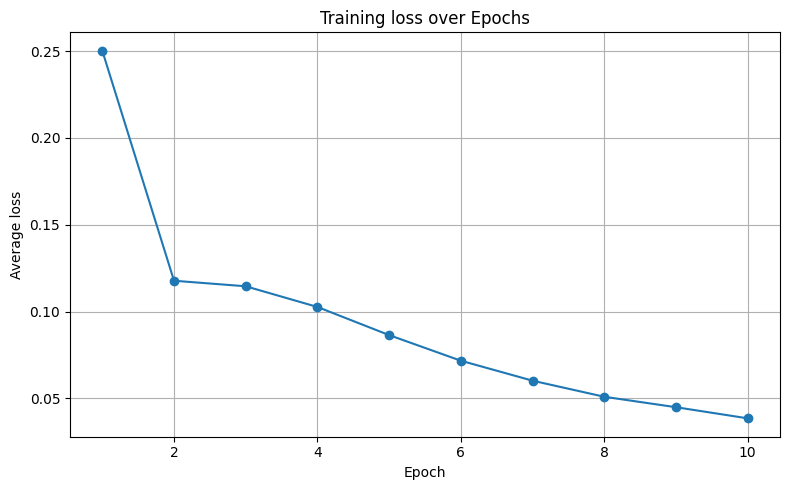

In [ ]:
# Plot the loss over the 10 epochs
plt.figure(figsize=(8, 5))
plt.plot(range(1, NUM_EPOCHS + 1), epoch_losses, marker='o')
plt.title('Training loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Average loss')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# More samples for testing
print(predict_title("Take On Me", model, input_vocab, target_vocab, MAX_INPUT_LEN, MAX_OUTPUT_LEN))
print(predict_title("God's Plan", model, input_vocab, target_vocab, MAX_INPUT_LEN, MAX_OUTPUT_LEN))
print(predict_title("Blinding Lights", model, input_vocab, target_vocab, MAX_INPUT_LEN, MAX_OUTPUT_LEN))
print(predict_title("Old Town Road", model, input_vocab, target_vocab, MAX_INPUT_LEN, MAX_OUTPUT_LEN))

Pop Edm
Hip Hop Wave
Pop Edm
Pop Edm


In [12]:
# Output BLEU score over 100 samples
smoothie = SmoothingFunction().method4

# Function for evaluating BLEU score
def evaluate_bleu(model, X_val, y_val, input_vocab, target_vocab, idx_to_target, max_input_len, max_output_len, num_samples=100):
    model.eval()
    bleu_scores = []

    for i in range(min(num_samples, len(X_val))):
        input_seq = X_val[i].unsqueeze(0)
        true_tokens = y_val[i].tolist()
        ref = [[idx_to_target[idx] for idx in true_tokens if idx > 1]]

        with torch.no_grad():
            encoder_outputs, hidden, cell = model.encoder(input_seq)
            input_token = torch.tensor([target_vocab.get('<PAD>', 0)])
            pred_tokens = []

            for _ in range(max_output_len):
                output, hidden, cell = model.decoder(input_token, hidden, cell, encoder_outputs)
                probs = torch.softmax(output, dim=1)
                probs[0][0] = 0
                pred_token = torch.multinomial(probs, 1).item()
                if pred_token == 0:
                    break
                pred_tokens.append(idx_to_target.get(pred_token, "<UNK>"))
                input_token = torch.tensor([pred_token])

        bleu = sentence_bleu(ref, pred_tokens, smoothing_function=smoothie)
        bleu_scores.append(bleu)

    avg_bleu = sum(bleu_scores) / len(bleu_scores)
    print(f"\nAverage BLEU score over {len(bleu_scores)} samples: {avg_bleu:.4f}")
    return avg_bleu

idx_to_target = {v: k for k, v in target_vocab.items()}
_ = evaluate_bleu(model, X_val, y_val, input_vocab, target_vocab, idx_to_target, MAX_INPUT_LEN, MAX_OUTPUT_LEN)


Average BLEU score over 100 samples: 0.0299
